**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

Here's some of the code you've written so far. Start by running it again.

In [2]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def split_dataset(X, y):
    train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)
    return  train_X, val_X, train_y, val_y



def catToNum(reduced_x_my_data,algo):
    selectColumns=[]
    count=0
    selCol=[colname for colname in reduced_x_my_data.select_dtypes("object")]
    if(algo=='factorize'):
        for colname in reduced_x_my_data.select_dtypes("object"):
            selectColumns.append(colname)
            count=count+1
            reduced_x_my_data[colname], labels = reduced_x_my_data[colname].factorize()
        print("\n Number of categorical features converted to int using factorize= {}".format(count))
        print('\n After cat to Num convertstion, below are the columns \n')
        print("{}".format(selectColumns))
        return reduced_x_my_data
    elif(algo=='label'):
        for colname in reduced_x_my_data.select_dtypes("object"):
            selectColumns.append(colname)
            count=count+1
            reduced_x_my_data[colname] = reduced_x_my_data[colname].astype("category").cat.codes()
        print("\n Number of categorical features converted to int using Label Encoding = {}".format(count))
        print('\n After cat to Num convertstion, below are the columns \n')
        print("{}".format(selectColumns))
        return reduced_x_my_data
    elif(algo=='ordinal'):
        ordinalencoder=OneHotEncoder(categories=selCol,handle_unknown="ignore")
        reduced_x_my_data[selCol] = ordinalencoder.fit_transform(reduced_x_my_data[selCol])
        for colname in reduced_x_my_data.select_dtypes("object"):
            selectColumns.append(colname)
            count=count+1
            #reduced_x_my_data[colname] = ordinal_encoder.fit_transform(X[colname])
        print("\n Number of categorical features converted to int using Label Encoding = {}".format(count))
        print('\n After cat to Num convertstion, below are the columns \n')
        print("{}".format(selectColumns))
        return reduced_x_my_data
       
    

def handleNullValues(X_df,algo):
    cols_with_missing = [col for col in X_df.columns if X_df[col].isnull().any()]
    print('\n handleNullValues : Below are cols with missing values for df with shape of df {}'.format(X_df.shape))
    print('\n Columns with msising values : {}'.format(len(cols_with_missing)))
    if(len(cols_with_missing)==0):
        print('\n NO MISSING VALUES IN COLUMNS .. CONGRATS ! \n')
    print(cols_with_missing)
    if algo=='impute':
        # Imputation
        my_imputer = SimpleImputer()
        imputed_X_df = pd.DataFrame(my_imputer.fit_transform(X_df))
        print("\n handleNullValue with imputer : shape of imputed df {}".format(imputed_X_df.shape))
        # Imputation removed column names; put them back
        imputed_X_df.columns = X_df.columns
        return imputed_X_df
    elif algo=='drop' : # remove col - approach 1 
        reduced_X_df = X_df.drop(cols_with_missing,axis=1)
        print("\n handleNullValue with drop : shape of dropped coln df {}".format(reduced_X_df.shape))
        return reduced_X_df
    else:
        print('\n \n NO COLUMNS MISSING VALUES REMOVED \n \n')
        return X_df
    
def score_dataset_rf(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    print(model.score(X_valid,y_valid))
    preds = model.predict(X_valid)
    explainModel(X_valid,y_valid,model)
    mae=mean_absolute_error(y_valid, preds)
    print('Random Forest Model Scored with MAE {}'.format(mae))
    return model,mae

       
def score_dataset_linear(X_train, X_valid, y_train, y_valid):
    print('Linear Model \n')
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(model.score(X_valid,y_valid))
    preds = model.predict(X_valid)
    explainModel(X_valid,y_valid,model)
    mae=mean_absolute_error(y_valid, preds)
    print('Linear Model Scored with MAE {}'.format(mae))
    return model,mae

def score_dataset_boost(X_train, X_valid, y_train, y_valid):
    """model = XGBRegressor(gamma=1,                
    learning_rate=0.01,
    max_depth=3,
    n_estimators=500,                                                                    
    subsample=0.6,
    random_state=34)    """
   # model.fit(X_train, y_train)
    #print(model.score(X_valid,y_valid))
    """ params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
    xgbr = XGBRegressor(seed = 20)
    clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1)
    clf.fit(X_train, y_train)
    print("Best parameters:", clf.best_params_)
    print("Lowest MAE: ", (-clf.best_score_)**(1/2.0))"""
    
    model = XGBRegressor(colsample_bytree=0.3, 
                         learning_rate= 0.01, 
                         max_depth= 6, 
                         n_estimators= 1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    explainModel(X_valid,y_valid,model)
    mae=mean_absolute_error(y_valid, preds)
    print('Boost Model Scored with MAE {}'.format(mae))
    return model,mae

def explainModel(X_valid, y_valid,model,algo='PermImp'):
     if algo=='PermImp':
        print('\nExplaining Model with ' + algo + '\n')
        #explain model
        perm = PermutationImportance(model, random_state=1).fit(X_valid, y_valid)
        # extract feature names 
        feature_names= [col for col in X_valid.columns]
         #not working
        #eli5.show_weights(perm, feature_names=feature_names) #= X_valid.columns.tolist())
        # use this to adjust features to be used
        print(eli5.format_as_text(eli5.explain_weights(model,top=15,feature_names=feature_names),show=('method', 'description', 'transition_features', 'targets', 'feature_importances', 'decision_tree'), highlight_spaces=None, show_feature_values=False))
    

        
    

# Train a model for the competition

The code cell above trains a Random Forest model on **`train_X`** and **`train_y`**.  

Use the code cell below to build a Random Forest model and train it on all of **`X`** and **`y`**.

Now, read the file of "test" data, and apply your model to make predictions.

shape (1460, 80)
shape (1460,)

 Number of categorical features converted to int using factorize= 43

 After cat to Num convertstion, below are the columns 

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

 handleNullValues : Below are cols with missing values for df with shape of df (1460, 80)

 Columns with msising values : 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

 handleNullValue with imputer : shape of imputed df (1460, 80)
shape123 (1460, 80)


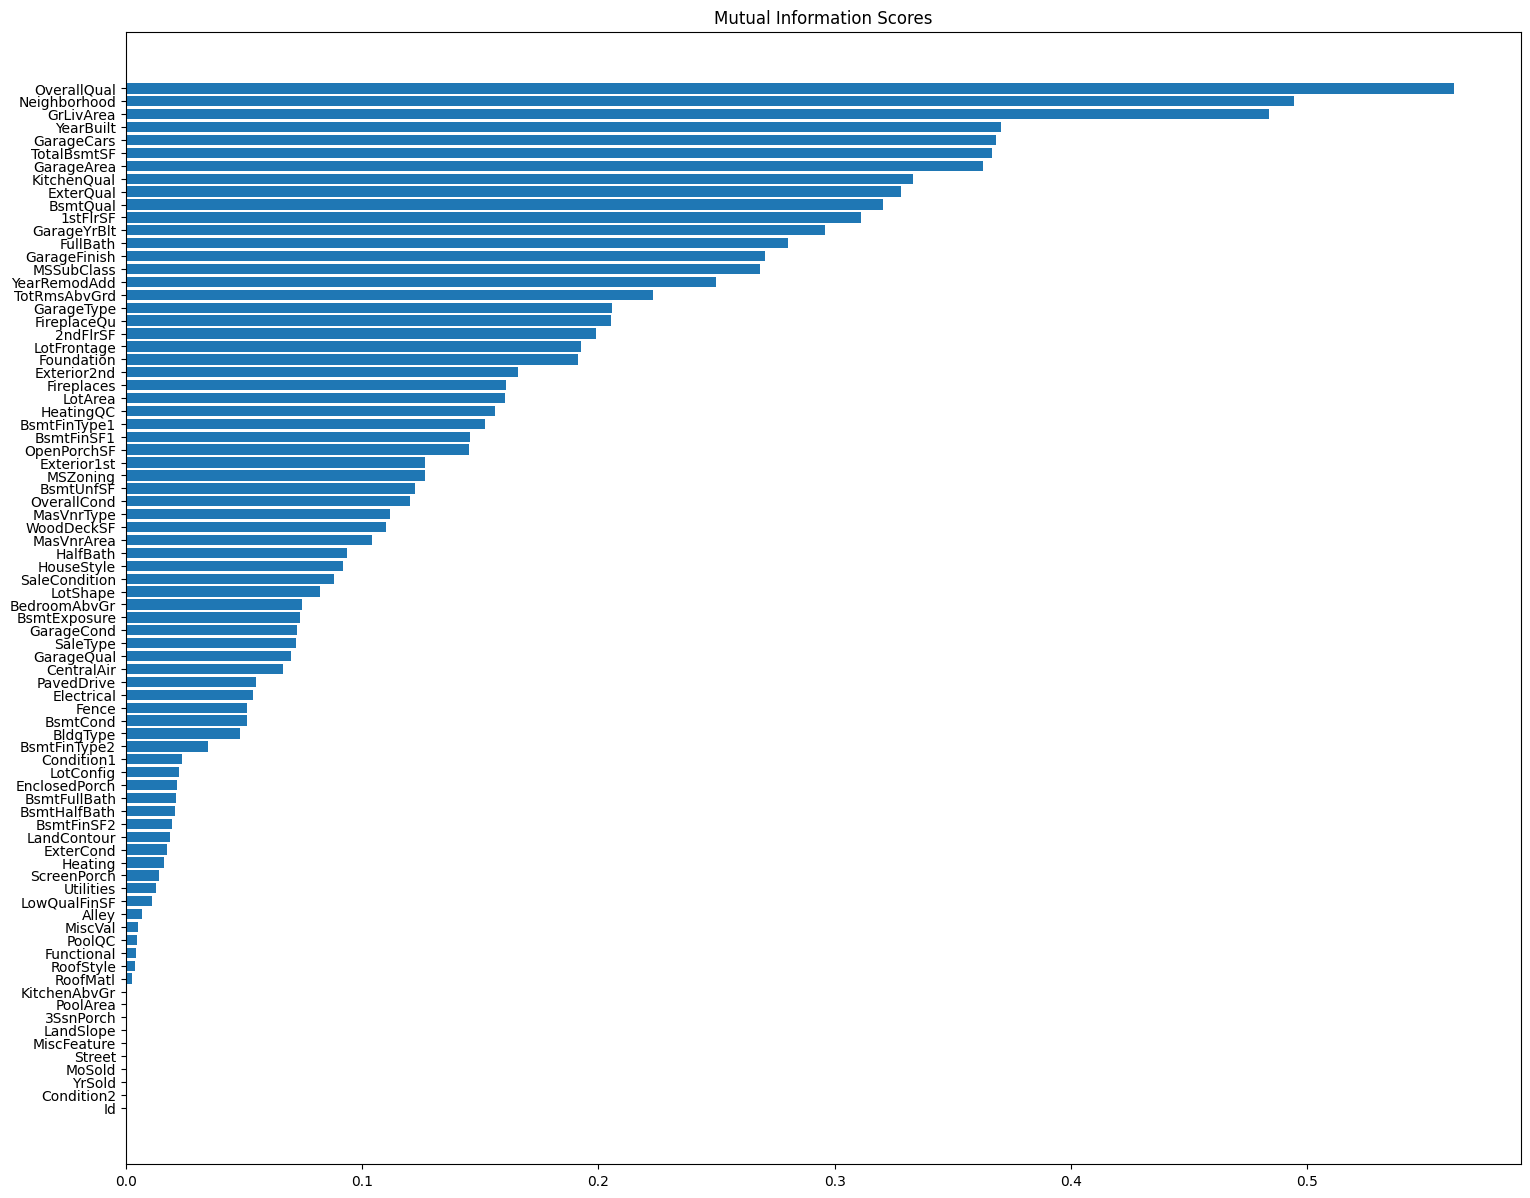

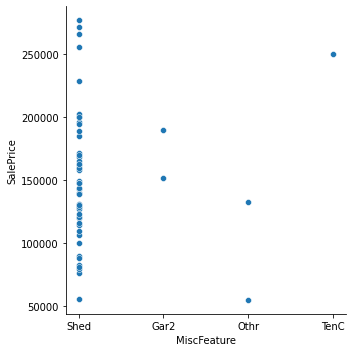

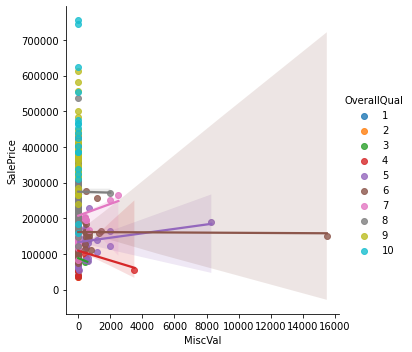

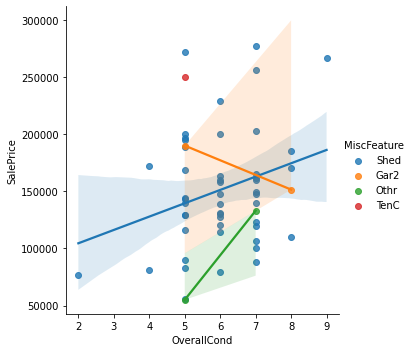

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Utility functions from Tutorial
def make_mi_scores_1(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    #discrete_features = X.dtypes == int [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #X.dtypes == int #['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']
#X.dtypes == int

#print("DIS{}".format(discrete_features.shape))
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)
X = home_data.copy()
y=X.pop('SalePrice')
print("shape {}".format(X.shape))
print("shape {}".format(y.shape))
c=catToNum(X,'factorize')
c=handleNullValues(c,'impute')
print("shape123 {}".format(c.shape))
discrete_features = X.dtypes == int
mi_scores = make_mi_scores_1(c, y)
mi_scores[0:35]
plt.figure(dpi=100, figsize=(18, 15))
plot_mi_scores(mi_scores[0:80])
sns.relplot(x="MiscFeature", y="SalePrice", data=home_data);
sns.lmplot(x="MiscVal", y="SalePrice", hue="OverallQual", data=home_data);
sns.lmplot(x="OverallCond", y="SalePrice", hue="MiscFeature", data=home_data);



In [4]:
c['MiscFeature'].head(50)
home_data['MiscFeature'].isnull().sum()

1406

In [5]:
mi_scores[35:80]

MasVnrArea       0.104017
HalfBath         0.093758
HouseStyle       0.091878
SaleCondition    0.088265
LotShape         0.082245
BedroomAbvGr     0.074768
BsmtExposure     0.073571
GarageCond       0.072283
SaleType         0.071847
GarageQual       0.069979
CentralAir       0.066337
PavedDrive       0.055042
Electrical       0.053940
Fence            0.051301
BsmtCond         0.051118
BldgType         0.048358
BsmtFinType2     0.034755
Condition1       0.023815
LotConfig        0.022481
EnclosedPorch    0.021531
BsmtFullBath     0.021159
BsmtHalfBath     0.020801
BsmtFinSF2       0.019451
LandContour      0.018843
ExterCond        0.017244
Heating          0.016070
ScreenPorch      0.013825
Utilities        0.012895
LowQualFinSF     0.011075
Alley            0.006978
MiscVal          0.004953
PoolQC           0.004860
Functional       0.004192
RoofStyle        0.003858
RoofMatl         0.002650
KitchenAbvGr     0.000312
Condition2       0.000000
YrSold           0.000000
MoSold      

In [6]:
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)
X = home_data.copy()
y= X.pop('SalePrice')
X.drop(["YrSold"],axis=1,inplace=True)
X.drop(["MoSold"],axis=1,inplace=True)
X.drop(["RoofMatl"],axis=1,inplace=True)
X.drop(["Condition2"],axis=1,inplace=True)
X.drop(["PoolQC"],axis=1,inplace=True)
X.drop(["SaleType"],axis=1,inplace=True)
X.drop(["Street"],axis=1,inplace=True)
X.drop(["3SsnPorch"],axis=1,inplace=True)
X.drop(["PoolArea"],axis=1,inplace=True)



test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path)


In [7]:
X.shape

(1460, 71)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant', fill_value=0))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

from sklearn.ensemble import RandomForestRegressor
my_pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestRegressor(n_estimators=10,random_state=0))
           ])

model_boost = XGBRegressor(colsample_bytree=0.4, #0.3
                         learning_rate= 0.01, 
                         max_depth= 5, 
                         n_estimators= 1000) #1000
xgbr = XGBRegressor(seed = 20)   
my_boost_pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('boost',model_boost)
           ])



In [9]:
X.shape

(1460, 71)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

X.head()

#rf_model = my_pipeline.fit(X, y)

#rf_scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
#boos_scores = -1 * cross_val_scorec, X, y, cv=5, scoring='neg_mean_absolute_error')

# Multiply by -1 since sklearn calculates *negative* MAE
#scores = -1 * cross_val_score(my_pipeline, X, y,                              cv=5,                              scoring='neg_mean_absolute_error')

#print("Average MAE score:", rf_scores.mean())
boost_scores = -1 * cross_val_score(my_boost_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
#boost_scores = -1 * cross_val_score(my_clf_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Boost Average MAE score: {}".format(boost_scores))
print("Boost Average MAE {}".format(boost_scores.mean()))
X.head()


Boost Average MAE score: [14643.40138057 15968.62707352 15414.38124732 13481.74673587
 15453.11635809]
Boost Average MAE 14992.254559075343


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,SaleCondition
0,1,60,RL,65.0,8450,NaN,Reg,Lvl,AllPub,Inside,...,TA,Y,0,61,0,0,NaN,NaN,0,Normal
1,2,20,RL,80.0,9600,NaN,Reg,Lvl,AllPub,FR2,...,TA,Y,298,0,0,0,NaN,NaN,0,Normal
2,3,60,RL,68.0,11250,NaN,IR1,Lvl,AllPub,Inside,...,TA,Y,0,42,0,0,NaN,NaN,0,Normal
3,4,70,RL,60.0,9550,NaN,IR1,Lvl,AllPub,Corner,...,TA,Y,0,35,272,0,NaN,NaN,0,Abnorml
4,5,60,RL,84.0,14260,NaN,IR1,Lvl,AllPub,FR2,...,TA,Y,192,84,0,0,NaN,NaN,0,Normal


Boost Average MAE score: 15077.821061643835

Boost Average MAE score: [14699.77068172 15749.16806239 15663.18570741 13355.02125696
 15582.52215325]

In [11]:
home_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
test_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [13]:
test_data.drop(["YrSold"],axis=1,inplace=True)
test_data.drop(["MoSold"],axis=1,inplace=True)
test_data.drop(["RoofMatl"],axis=1,inplace=True)
test_data.drop(["Condition2"],axis=1,inplace=True)
test_data.drop(["PoolQC"],axis=1,inplace=True)
test_data.drop(["SaleType"],axis=1,inplace=True)
test_data.drop(["Street"],axis=1,inplace=True)
test_data.drop(["3SsnPorch"],axis=1,inplace=True)
test_data.drop(["PoolArea"],axis=1,inplace=True)

In [14]:
X.shape


(1460, 71)

In [15]:
test_data.shape

(1459, 71)

In [16]:
my_boost_pipeline.fit(X,y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=5, min_

In [17]:
test_preds=my_boost_pipeline.predict(test_data)

In [18]:

above_0_missing = test_data.isnull().sum() > 0
print(test_data.isnull().sum()[above_0_missing])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
Fence           1169
MiscFeature     1408
dtype: int64


Average MAE score: 18902.309315068494
Boost Average MAE score: 15044.576933806327

Before submitting, run a check to make sure your `test_preds` have the right format.

In [19]:
# Check your answer (To get credit for completing the exercise, you must get a "Correct" result!)
step_1.check()
#step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [20]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.